# Deep Learning

## Examen Agosto 2022 - Embeddings

## Ejercicio 3.

Descargar el dataset desde el [siguiente link](https://drive.google.com/file/d/1r1vnIW0jL1LJBrT_QVcQz_Sjizwa0adR/view). El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).
- a) Entrenar un modelo de deep learning que no utilice embeddings.
- b) Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
- c) Compare el score de cada modelo y comente lo necesario.

### Librerías y funciones globales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

### 1. EDA

In [2]:
dataset = pd.read_csv('data/dataset_2.csv')

In [3]:
df = dataset.copy(deep=True)

In [4]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [7]:
df.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

### Creamos la variable target y analizamos su distrbución

In [8]:
df['target'] = df['Purchase'].apply(lambda x: 1 if x >= 9000 else 0)

<AxesSubplot:ylabel='target'>

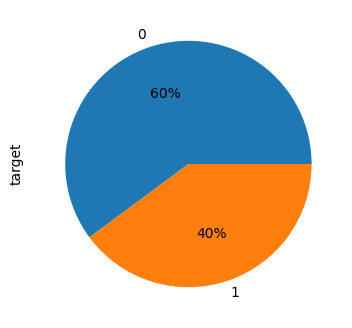

In [9]:
df['target'].value_counts().plot.pie(autopct='%1.0f%%', figsize=(4,4))

In [10]:
# 0 -> compra menos de 9000
# 1 -> compra 9000 o más
df['target'].value_counts()

0    330871
1    219197
Name: target, dtype: int64

### Eliminamos la variable Purchase

In [11]:
df.drop(['Purchase'], axis=1, inplace=True)

### Eliminamos la variable Product_Category_2 y Product_Category_3
- Las eliminamos ya que superan el 25% de valores nulos

In [12]:
df.drop(['Product_Category_2'], axis=1, inplace=True)
df.drop(['Product_Category_3'], axis=1, inplace=True)

### Renombramos las columnas restantes

In [13]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'target'],
      dtype='object')

In [14]:
columns = {
    'User_ID': 'user_id',
    'Product_ID': 'product_id',
    'Gender': 'gender',
    'Age': 'age',
    'Occupation': 'occupation',
    'City_Category': 'city_category',
    'Stay_In_Current_City_Years': 'stay_in_current_city_years',
    'Marital_Status': 'marital_status',
    'Product_Category_1': 'product_category_1',
    'target': 'target',
}

In [15]:
df.rename(columns=columns, inplace=True)

### Ingeniería de features

In [16]:
df.head()

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,target
0,1000001,P00069042,F,0-17,10,A,2,0,3,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,1
2,1000001,P00087842,F,0-17,10,A,2,0,12,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,0


#### Variable user_id: embeddings

In [17]:
# Analicemos la variable user_id
print(f'Cantidad de elementos únicos: {len(df["user_id"].unique())}')
user_ids = df["user_id"]
df.drop(["user_id"], axis=1, inplace=True)

Cantidad de elementos únicos: 5891


#### Variable product_id: embeddings

In [18]:
# Analicemos la variable product_id
print(f'Cantidad de elementos únicos: {len(df["product_id"].unique())}')
product_ids = df["product_id"]
df.drop(["product_id"], axis=1, inplace=True)

Cantidad de elementos únicos: 3631


#### Variables gender: binarización

In [19]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'F' else 0)

#### Variables categóricas:

In [20]:
categorical_columns = ['age', 'occupation', 'city_category', 'stay_in_current_city_years', 'product_category_1']

In [21]:
for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column) 
    df = pd.concat([df, dummies], axis=1)
    df.drop([column], axis=1, inplace=True)

### Normalización

In [22]:
X_columns = list(df.columns)

In [23]:
X_columns.remove('target')

In [24]:
X = df[X_columns]

In [25]:
y = df['target']

In [26]:
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [27]:
print(np.min(X_norm, axis=0))
print(np.max(X_norm, axis=0))

gender                           0.0
marital_status                   0.0
age_0-17                         0.0
age_18-25                        0.0
age_26-35                        0.0
age_36-45                        0.0
age_46-50                        0.0
age_51-55                        0.0
age_55+                          0.0
occupation_0                     0.0
occupation_1                     0.0
occupation_2                     0.0
occupation_3                     0.0
occupation_4                     0.0
occupation_5                     0.0
occupation_6                     0.0
occupation_7                     0.0
occupation_8                     0.0
occupation_9                     0.0
occupation_10                    0.0
occupation_11                    0.0
occupation_12                    0.0
occupation_13                    0.0
occupation_14                    0.0
occupation_15                    0.0
occupation_16                    0.0
occupation_17                    0.0
o

In [28]:
X_norm.describe()

,gender,marital_status,age_0-17,age_18-25,age_26-35,age_36-45,age_46-50,age_51-55,age_55+,occupation_0,...,product_category_1_11,product_category_1_12,product_category_1_13,product_category_1_14,product_category_1_15,product_category_1_16,product_category_1_17,product_category_1_18,product_category_1_19,product_category_1_20
count,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,...,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,0.246895,0.409653,0.027455,0.181178,0.399200,0.199999,0.083082,0.069993,0.039093,0.126599,...,0.044153,0.007175,0.010088,0.002769,0.011435,0.017867,0.001051,0.005681,0.002914,0.004636
std,0.431205,0.491770,0.163405,0.385166,0.489734,0.400000,0.276007,0.255136,0.193817,0.332523,...,0.205435,0.084404,0.099930,0.052546,0.106321,0.132468,0.032399,0.075159,0.053905,0.067929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split

In [29]:
X_norm = X_norm.to_numpy()
y = y.to_numpy()
n = X_norm.shape[0]
print(n)
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.85 * n)]
valid_idx = idx[int(0.85 * n):]
print(len(train_idx))
print(len(valid_idx))

# train -> entrenar tu modelo (80%)
# valid -> encontrar los HPs (10%)
# test -> calcular las metricas finales (10%)

550068
467557
82511


In [30]:
X_train = X_norm[train_idx,:]
y_train = y[train_idx]
X_valid = X_norm[valid_idx,:]
y_valid = y[valid_idx]

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(467557, 58)
(467557,)
(82511, 58)
(82511,)


# NNet with embeddings

In [31]:
user_ids_unique = np.unique(user_ids)
index_user_ids = np.arange(0, len(user_ids_unique))
user_id_to_index = {key: value for key, value in zip(user_ids_unique, index_user_ids)}

product_ids_unique = np.unique(product_ids)
index_product_ids = np.arange(0, len(product_ids_unique))
product_id_to_index = {key: value for key, value in zip(product_ids_unique, index_product_ids)}

In [32]:
users_idx = np.array([user_id_to_index[user] for user in user_ids])

In [33]:
products_idx = np.array([product_id_to_index[product] for product in product_ids])

In [34]:
class CustomDatasetWithEmb(Dataset):

    def __init__(self, X, users_idx, products_idx, y):
        super().__init__()
        self.X = X
        self.users_idx = users_idx
        self.products_idx = products_idx
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.users_idx[idx], self.products_idx[idx], self.y[idx]

In [35]:
users_index_train = users_idx[train_idx]  
users_index_val = users_idx[valid_idx]

products_index_train = products_idx[train_idx]  
products_index_val = products_idx[valid_idx]

train = CustomDatasetWithEmb(X_train, users_index_train, products_index_train, y_train)
valid = CustomDatasetWithEmb(X_valid, users_index_val, products_index_val, y_valid)

In [36]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [37]:
class NNetWithEmbeddings(torch.nn.Module):

    def __init__(self, number_of_users, number_od_products, d):
        super().__init__()
        self.embedding_1 = torch.nn.Embedding(num_embeddings=number_of_users, embedding_dim=d)
        self.embedding_2 = torch.nn.Embedding(num_embeddings=number_od_products, embedding_dim=d)
        
        self.linear_1 = torch.nn.Linear(in_features=(58+d+d), out_features=128, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=256, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=256, out_features=1, bias=True)
        self.output = torch.nn.Sigmoid()

    def forward(self, x, user_idx, product_idx):
        user_emb = self.embedding_1(user_idx)
        prod_emb = self.embedding_2(product_idx)

        final_input = torch.cat([x, user_emb, prod_emb], dim=1)

        x = self.linear_1(final_input) 
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)        
        x = self.linear_3(x)
        x = self.output(x)
        return x

In [38]:
nnet2 = NNetWithEmbeddings(number_of_users=5891, number_od_products=3631, d=8)
optimizer = torch.optim.Adam(nnet2.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [39]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cuda:0


In [40]:
print(nnet2)

NNetWithEmbeddings(
  (embedding_1): Embedding(5891, 8)
  (embedding_2): Embedding(3631, 8)
  (linear_1): Linear(in_features=74, out_features=128, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=256, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=256, out_features=1, bias=True)
  (output): Sigmoid()
)


In [41]:
nnet = nnet2

nnet.to(device)

loss_list = []
train_auc = []
for epoch in range(100):

    running_loss = 0
    running_y_score = []
    running_y_label = []

    #### TRAINING ####

    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, user_idx_batch, product_idx_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        user_idx_batch = user_idx_batch.to(device)
        product_idx_batch = product_idx_batch.to(device)
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch, user_idx_batch, product_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

Epoch 0 | Training loss: 286493.39155578613 | AUC: 0.874095300832982
Epoch 1 | Training loss: 284476.14011764526 | AUC: 0.8863075611175634
Epoch 2 | Training loss: 282717.5353717804 | AUC: 0.8919951037650569
Epoch 3 | Training loss: 281722.4368724823 | AUC: 0.8985290387763407
Epoch 4 | Training loss: 280875.32644844055 | AUC: 0.9062806139233899
Epoch 5 | Training loss: 280272.88443756104 | AUC: 0.9124526493704088
Epoch 6 | Training loss: 279770.99044418335 | AUC: 0.9139022389667931
Epoch 7 | Training loss: 279398.25131988525 | AUC: 0.916998656986109
Epoch 8 | Training loss: 278997.3756942749 | AUC: 0.9178283922903053
Epoch 9 | Training loss: 278701.93734169006 | AUC: 0.9184379935232938
Epoch 10 | Training loss: 278387.23546409607 | AUC: 0.9184643785331777
Epoch 11 | Training loss: 278135.6034755707 | AUC: 0.918397874152945
Epoch 12 | Training loss: 277923.32148361206 | AUC: 0.9180660671747264
Epoch 13 | Training loss: 277686.6334400177 | AUC: 0.9192253412023055
Epoch 14 | Training loss

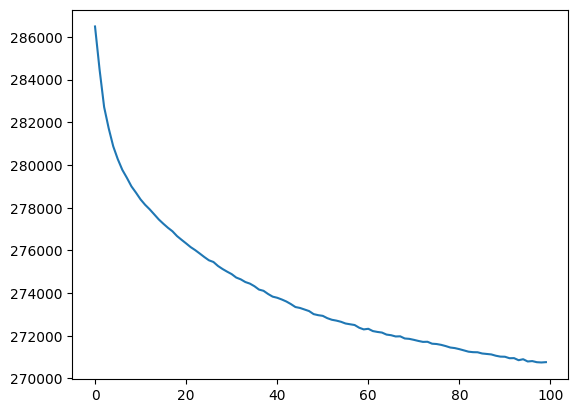

In [43]:
fig, ax1 = plt.subplots(1, 1)
x = range(0, len(loss_list))
ax1.plot(x, loss_list)

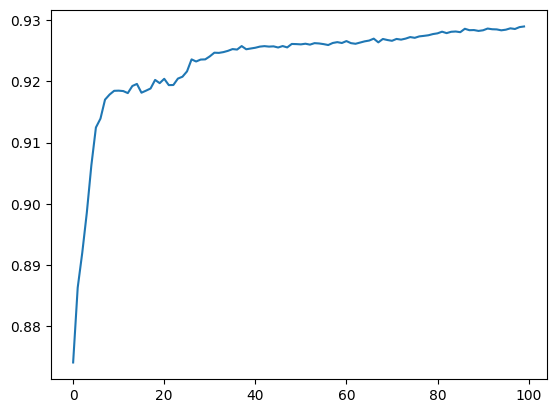

In [44]:
fig, ax1 = plt.subplots(1, 1)
x = range(0, len(train_auc))
ax1.plot(x, train_auc)

### Conclusiones

Es posible notar como al utilizar embeddings para el id de usuario y de productos, disminuya le pérdida y aumenta el AUC respecto al modelo que no los utiliza. Mientras el AUC es cercano al 0.93 emplando embeddings, es cercano a 0.87 sin utilizarlos (ambos casos tomando como ejemplo el conjunto de test).